In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix


In [57]:
df_test=pd.read_csv('test_data.txt', sep=':::',names=['ID', 'Title', 'Description'],engine='python')
df_train=pd.read_csv('train_data.txt', sep=':::',names=['Title', 'Genre', 'Description'],engine='python')
df_test_solution=pd.read_csv('test_data_solution.txt', sep=':::',names=['Genre', 'Description'],engine='python')

In [58]:
df_train

,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...
...,...,...,...
54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on ...
54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The sist...
54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about g..."
54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and hav...


In [59]:
df_test

,ID,Title,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...
...,...,...,...
54195,54196,"""Tales of Light & Dark"" (2013)","Covering multiple genres, Tales of Light & Da..."
54196,54197,Der letzte Mohikaner (1965),As Alice and Cora Munro attempt to find their...
54197,54198,Oliver Twink (2007),A movie 169 years in the making. Oliver Twist...
54198,54199,Slipstream (1973),"Popular, but mysterious rock D.J Mike Mallard..."


# EDA

In [60]:
#checking for null values
df_train.isnull().sum()

Title          0
Genre          0
Description    0
dtype: int64

In [61]:
df_train.describe()

,Title,Genre,Description
count,54214,54214,54214
unique,54214,27,54086
top,Oscar et la dame rose (2009),drama,Grammy - music award of the American academy ...
freq,1,13613,12


In [62]:
classDistribution= df_train['Genre'].value_counts()
print("Class Distribution:")
print(classDistribution)

Class Distribution:
Genre
drama           13613
documentary     13096
comedy           7447
short            5073
horror           2204
thriller         1591
action           1315
western          1032
reality-tv        884
family            784
adventure         775
music             731
romance           672
sci-fi            647
adult             590
crime             505
animation         498
sport             432
talk-show         391
fantasy           323
mystery           319
musical           277
biography         265
history           243
game-show         194
news              181
war               132
Name: count, dtype: int64


In [63]:
imbalance_ratio = classDistribution.min() / classDistribution.max()
print("Imbalance Ratio:", imbalance_ratio)

Imbalance Ratio: 0.009696613531183427


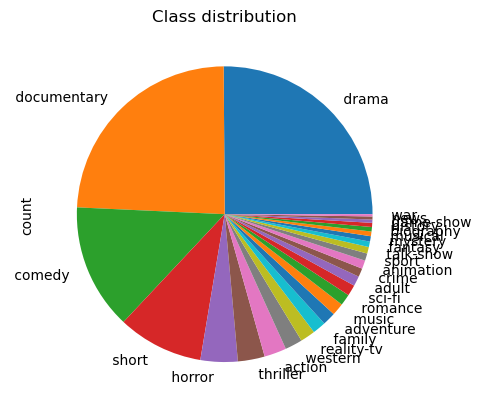

In [64]:
df_train['Genre'].value_counts().plot(kind='pie')
plt.title("Class distribution")
plt.show()

# DATA PREPROCESSING
+ lowercasing, removing whitespaces  and duplicates
+ Removing punctuation and numbers   
+ removing special character   
+ removing stop words
+ Lemmerization  

In [65]:
#lowercasing and stripping whitespace from Titles and Descriptions
df_train['Description'] = df_train['Description'].str.strip().str.lower()
df_train['Title'] = df_train['Title'].str.strip().str.lower()

#checking for duplicates in Titles and Descriptions
b=df_train.duplicated(subset='Title', keep=False).sum()
a=df_train.duplicated(subset='Description', keep=False).sum()
print(f"Number of duplicate Titles in train data: {b}")
print(f"Number of duplicate Descriptions in train data: {a}")



Number of duplicate Titles in train data: 8
Number of duplicate Descriptions in train data: 206


In [66]:
df_train.shape

(54214, 3)

In [67]:
#remvoing duplicates based on Titles and Descriptions
df_train = df_train.drop_duplicates(subset='Description')
df_train = df_train.drop_duplicates(subset='Title')

#checking for duplicates in Titles and Descriptions
b=df_train.duplicated(subset='Title', keep=False).sum()
a=df_train.duplicated(subset='Description', keep=False).sum()
print(f"Number of duplicate Titles in train data: {b}")
print(f"Number of duplicate Descriptions in train data: {a}")



Number of duplicate Titles in train data: 0
Number of duplicate Descriptions in train data: 0


In [68]:
df_train.shape

(54083, 3)

In [69]:
df_train.isnull().sum()

Title          0
Genre          0
Description    0
dtype: int64

In [70]:
#remvoing punctuation

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

df_train['Description'] = df_train['Description'].apply(remove_punctuation)
df_train['Title'] = df_train['Title'].apply(remove_punctuation)
df_test['Description'] = df_test['Description'].apply(remove_punctuation)
df_test['Title'] = df_test['Title'].apply(remove_punctuation)



In [71]:
#removing numbers

def remove_numbers(text):
    return re.sub(r'\d+', '', text)

df_train['Description'] = df_train['Description'].apply(remove_numbers)
df_train['Title'] = df_train['Title'].apply(remove_numbers)
df_test['Description'] = df_test['Description'].apply(remove_numbers)
df_test['Title'] = df_test['Title'].apply(remove_numbers)


In [72]:
#removing Special Characters
def remove_special_characters(text):
    return re.sub(r'[^A-Za-z0-9\s]', '', text)

df_train['Description'] = df_train['Description'].apply(remove_special_characters)
df_train['Title'] = df_train['Title'].apply(remove_special_characters)
df_test['Description'] = df_test['Description'].apply(remove_special_characters)
df_test['Title'] = df_test['Title'].apply(remove_special_characters)

In [73]:
#removing stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

df_train['Description'] = df_train['Description'].apply(remove_stopwords)
df_train['Title'] = df_train['Title'].apply(remove_stopwords)
df_test['Description'] = df_test['Description'].apply(remove_stopwords)
df_test['Title'] = df_test['Title'].apply(remove_stopwords)


In [74]:
#remvoing whitespace
df_train['Description'] = df_train['Description'].str.strip()
df_train['Description'] = df_train['Description'].str.replace(r'\s+', ' ', regex=True)
df_test['Title'] = df_test['Title'].str.strip()
df_test['Title'] = df_train['Title'].str.replace(r'\s+', ' ', regex=True)

In [75]:
df_train.shape

(54083, 3)

In [76]:
#predicting genre from description only 
X_train_description = df_train['Description']
y_train = df_train['Genre']

X_test_description = df_test['Description']
y_test = df_test_solution['Genre']


In [77]:
X_train_description.shape

(54083,)

In [78]:
y_train.shape

(54083,)

In [79]:
lemmatizer = WordNetLemmatizer()

def lemmatizer_with_verb(sentence):
    return ' '.join(
        lemmatizer.lemmatize(word, pos='v') 
        for word in word_tokenize(sentence)
    )
def lemmatizer_with_adjective(sentence):
    return ' '.join(
        lemmatizer.lemmatize(word, pos='a') 
        for word in word_tokenize(sentence)
    )
X_train_description = X_train_description.apply(lemmatizer_with_verb)
# X_train_description = X_train_description.apply(lemmatizer_with_adjective)

X_test_description = X_test_description.apply(lemmatizer_with_verb)
# X_test_description = X_test_description.apply(lemmatizer_with_adjective)


In [80]:
X_train_description.shape

(54083,)

In [81]:
y_train.shape

(54083,)

In [122]:
tfidf = TfidfVectorizer( max_features=8000)
X_train_tfidf = tfidf.fit_transform(X_train_description)
X_test_tfidf = tfidf.transform(X_test_description)

In [131]:
#logisticRegression
model = LogisticRegression(max_iter=4000,class_weight='balanced')

In [132]:
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)


print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Test Accuracy: 0.4587822878228782
               precision    recall  f1-score   support

      action        0.34      0.48      0.39      1314
       adult        0.33      0.66      0.44       590
   adventure        0.20      0.33      0.25       775
   animation        0.17      0.30      0.21       498
   biography        0.05      0.19      0.08       264
      comedy        0.61      0.43      0.51      7446
       crime        0.13      0.35      0.19       505
 documentary        0.80      0.54      0.64     13096
       drama        0.72      0.37      0.49     13612
      family        0.15      0.33      0.21       783
     fantasy        0.10      0.25      0.14       322
   game-show        0.58      0.73      0.65       193
     history        0.07      0.28      0.11       243
      horror        0.56      0.65      0.60      2204
       music        0.36      0.70      0.48       731
     musical        0.14      0.34      0.19       276
     mystery        0.08      